# Import

In [1]:
from mne.io.snirf import read_raw_snirf
from get_events_from_snirf import get_events_from_snirf
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import mne
import mne_nirs
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [2]:
from give_channels import give_channels

In [3]:
from mne_nirs.channels import (get_long_channels, get_short_channels, picks_pair_to_idx)

# Class

In [4]:
class SNRF:
    def __init__(self, path, hojjat = False):
        self.path = path
        self.snirf = read_raw_snirf(path)
        self.sfreq = self.snirf.info['sfreq']
        self.events = get_events_from_snirf(path, hojjat)
        self.data = self.snirf.get_data()
        self.clean()
        self.filt()
        self.data_right, self.data_avg_right = self.plot(self.filtered_data, self.events, 'Right')
        self.data_left, self.data_avg_left = self.plot(self.filtered_data, self.events, 'Left')
        # self.data_rest, self.data_avg_rest = self.plot(self.filtered_data, self.events, 'Rest')
        
    def clean(self):
        nans = np.isnan(self.data)
        nans_sum = np.sum(nans, axis=1)
        nans_ids = nans_sum > 0
        self.clean_data = self.data[~nans_ids, :]
        self.clean_channels = np.array(self.snirf.ch_names)[~nans_ids]
        
    def get_duration(self, events):
        duration = events[events['Duration'].round() >0].Duration.min().round().astype(int)
        return duration
    
    def get_start_indexes(self, events):
        start_indexes = ((events.Timestamp.values - 5) * self.sfreq).round().astype(int)
        return start_indexes
    def get_events_start_block(self, events, label):
        if label == 'Rest':
            events = events[(events.Duration > 2) & (events.Event == 'StartRest')]
        else:
            events = events[(events.BlockType == label) & (events.Event == 'StartBlock')]
        return events
    
    def get_data(self, all_data, start_indexes, duration):
        tmp = [all_data[:, start_index:start_index + int(duration*self.sfreq)] for start_index in start_indexes]
        # print([np.shape(t) for t in tmp])
        data = np.array(tmp)
        return data
    
    def get_data_avg(self, data):
        data_avg = np.mean(data, axis=0)
        return data_avg
    
    def plot(self,all_data, all_events, label):
        events = self.get_events_start_block(all_events, label)
        duration = self.get_duration(events) + (0 if label == 'Rest' else 20 )
        start_indexes = self.get_start_indexes(events)
        data = self.get_data(all_data, start_indexes, duration)
        data_avg = self.get_data_avg(data)
        # plt.pcolor( data_avg, shading='auto', cmap='binary')
        # _plot(snirf, data_avg, duration)
        return data, data_avg
    
    def filt(self):
        self.filtered_data = gaussian_filter1d(self.clean_data, 5, axis=1)
        
    def find_channels(self, start, channels, o2):
        out = [ch for ch in channels if ch.startswith(start) and ch.endswith(o2) ]
        out = np.array(out)
        return out

    def find_channel_indexes(self, channels, filt):
        out = [i for i, ch in enumerate(channels) if ch in filt]
        out = np.array(out)
        return out
    
    def pick(self, start, o2):
        tmp = self.find_channels(start,self.clean_channels, o2)
        indexes = self.find_channel_indexes(self.clean_channels, tmp)
        return indexes    

# Load File

In [5]:
path_1 = '../data_hojjat/retinostopy/s1/1/test_001_S001_35d961a_5.snirf'

In [6]:
snirf_1 = SNRF(path_1)
# snirf_2 = SNRF(path_2)
# snirf

Loading /home/kernel/Desktop/py_test/project/kernel_stuff/../data_hojjat/retinostopy/s1/1/test_001_S001_35d961a_5.snirf


AttributeError: 'float' object has no attribute 'round'

In [7]:
raw = read_raw_snirf(path_1, preload=True)
len(raw.ch_names)

Loading /home/kernel/Desktop/py_test/project/kernel_stuff/../data_hojjat/retinostopy/s1/1/test_001_S001_35d961a_5.snirf
Reading 0 ... 3155  =      0.000 ...   442.015 secs...


4156

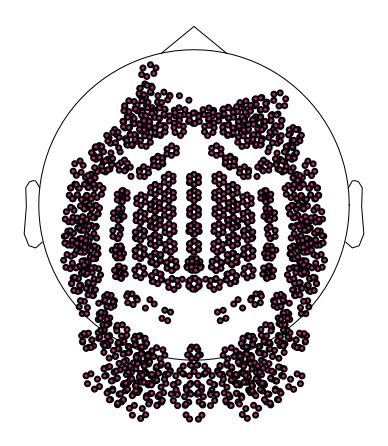

In [8]:
raw.plot_sensors();

In [9]:
short_chs = get_short_channels(raw);
raw  = get_long_channels(raw);

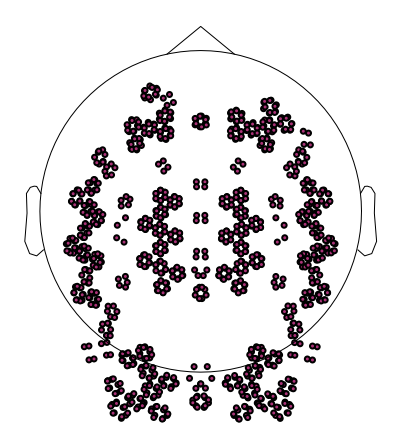

In [10]:
raw.plot_sensors();

In [11]:
len(short_chs)

3156

In [12]:
len(raw.ch_names)

2138

In [ ]:
raw.info

In [13]:
raw_backup = raw.copy()

In [14]:
short_backup = short_chs.copy()

In [15]:
raw = raw_backup.copy()

In [16]:
short_chs = short_backup.copy()

In [72]:
vis = ['S50', 'S49', 'S48', 'S47', 'S46', 'S45', 'S44', 'S43', 'S42', 'S41','S40', 'S39']

In [76]:
raw_channels = np.array(raw.ch_names)

In [79]:
short_channels = np.array(short_chs.ch_names)

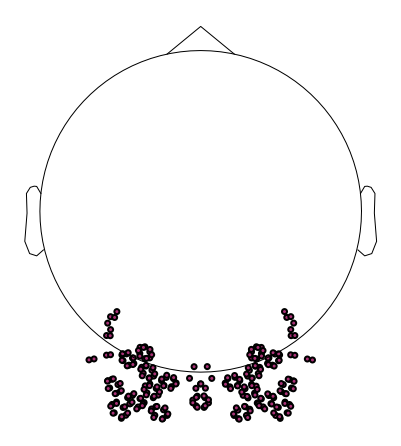

In [74]:
raw.copy().pick(raw_channels[[True if any([ch.startswith(viz) for viz in vis]) else False for ch in raw_channels]]).plot_sensors();

In [80]:
raw.pick(raw_channels[[True if any([ch.startswith(viz) for viz in vis]) else False for ch in raw_channels]]);
short_chs.pick(short_channels[[True if any([ch.startswith(viz) for viz in vis]) else False for ch in short_channels]]);

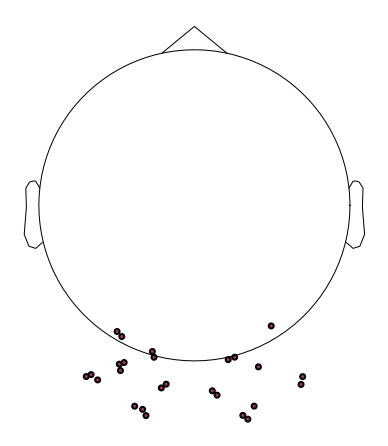

In [81]:
short_chs.plot_sensors();

# Stats

In [ ]:
from scipy import stats

In [ ]:
def get_window(data, t1, t2, sfreq):
    t1 = int(t1*sfreq)
    t2 = int(t2*sfreq)
    return data[:, :, t1:t2]

In [ ]:
def get_normalized_window(data, baseline_start, baseline_end, window_start, window_end, sfreq):
    baselines = get_window(data, baseline_start, baseline_end, sfreq)
    windows = get_window(data, window_start, window_end, sfreq)

    baseline_avg = np.mean(baselines, axis=2)
    baseline_std = np.std(baselines, axis=2)

    baseline_avg_rep = np.repeat(baseline_avg[:, :, np.newaxis], windows.shape[2], axis=2)
    baseline_std_rep = np.repeat(baseline_std[:, :, np.newaxis], windows.shape[2], axis=2)

    windows = (windows - baseline_avg_rep) / baseline_std_rep

    return windows

In [ ]:
right_windows = get_normalized_window(snirf_1.data_right, 0, 5, 7, 14, snirf_1.sfreq)
left_windows = get_normalized_window(snirf_1.data_left, 0, 5, 7, 14, snirf_1.sfreq)
rest_windows = get_window(snirf_1.data_rest, 2, 7, snirf_1.sfreq)

In [ ]:
right_window_means = np.mean(right_windows, axis = 2)
left_window_means = np.mean(left_windows, axis = 2)
rest_window_means = np.mean(rest_windows, axis = 2)

In [ ]:
right_window_means.shape

In [ ]:
sta, ps = stats.ttest_ind( right_window_means, left_window_means, alternative='greater')

In [ ]:
np.sum(ps < 0.05)

In [ ]:
len(snirf_1.clean_channels)

In [ ]:
raw.copy().pick(snirf_1.clean_channels[ps < 0.005]).plot_sensors();

In [ ]:
rvs1.shape

In [ ]:
sta, ps = stats.ttest_ind(rvs1, rvs2, axis=1)

In [ ]:
sta.shape

In [ ]:
ps.shape

In [87]:
raw_data = raw.get_data()

In [90]:
nan_sum = np.sum(np.isnan(raw_data), axis=1)

In [100]:
(np.where(nan_sum == 0)[0]).shape

(172,)

In [103]:
raw_nan = raw.copy().pick( (np.where(nan_sum == 0)[0]) )

In [ ]:
print(len(snirf_1.clean_channels))
len(raw.ch_names)

Effective window size : 286.925 (s)
Effective window size : 286.925 (s)


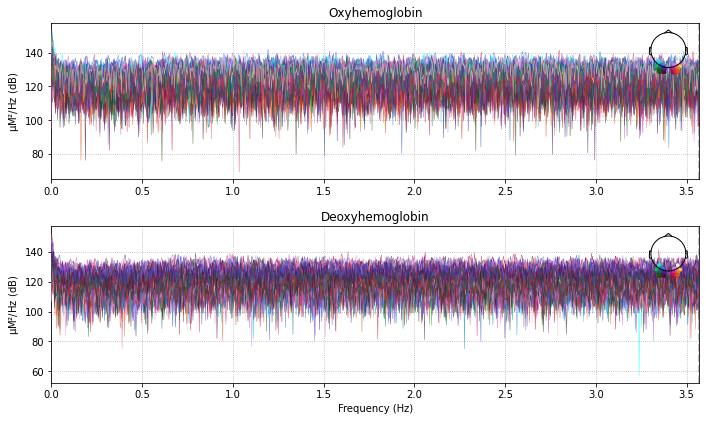

In [104]:
raw_nan.plot_psd(average=False);

Effective window size : 286.925 (s)
Effective window size : 286.925 (s)


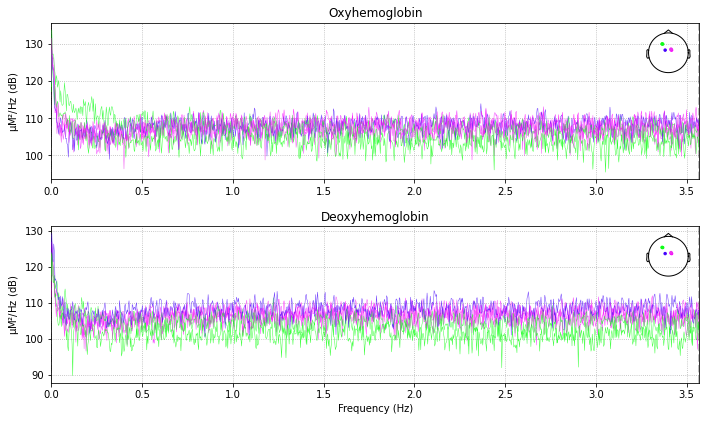

In [18]:
short_chs.plot_psd(average=False);

Effective window size : 286.925 (s)
Effective window size : 286.925 (s)


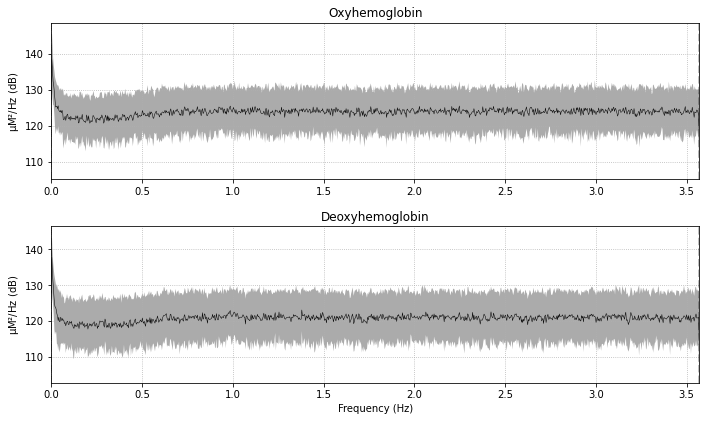

In [105]:
raw_nan.plot_psd(average=True);

Effective window size : 286.925 (s)
Effective window size : 286.925 (s)


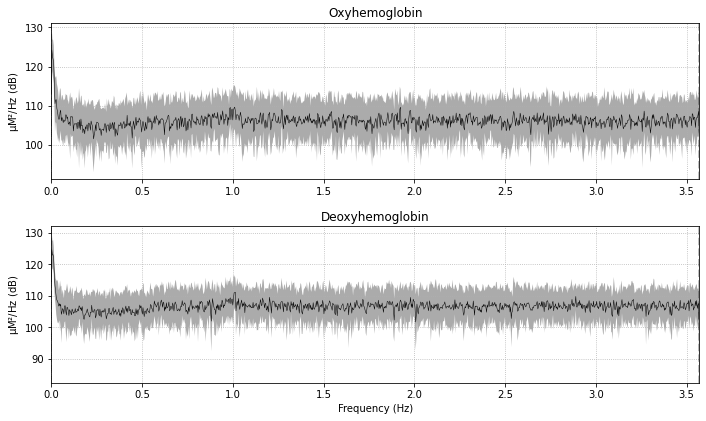

In [106]:
short_chs.plot_psd(average=True);

In [107]:
raw = raw_nan.filter(0.0, 0.07, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02);
short_chs = short_chs.filter(0.05, 0.07, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02);

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.07 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.07 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.17 Hz)
- Filter length: 119 samples (16.672 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.07 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.07 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.17 Hz)
- Filter length: 1179 

Effective window size : 286.925 (s)
Effective window size : 286.925 (s)


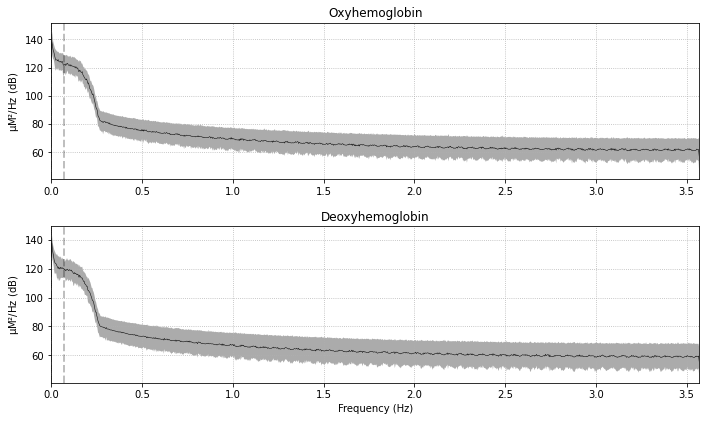

In [108]:
raw.plot_psd(average=True);

Effective window size : 286.925 (s)
Effective window size : 286.925 (s)


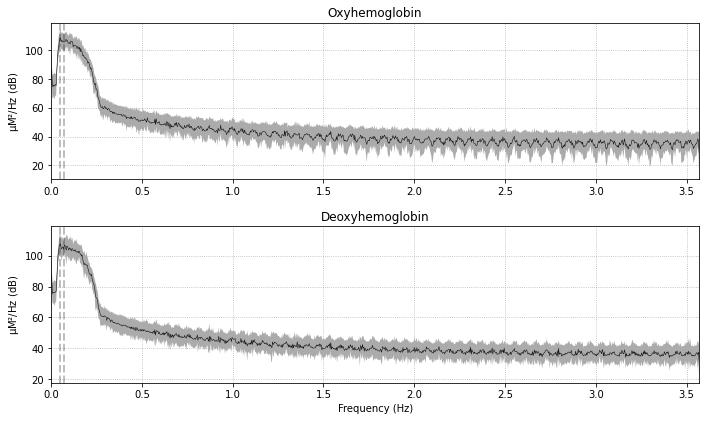

In [109]:
short_chs.plot_psd(average=True);

Effective window size : 286.925 (s)
Effective window size : 286.925 (s)


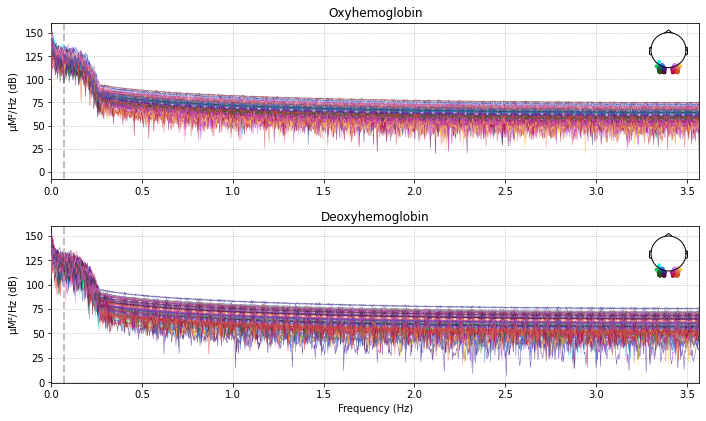

In [110]:
raw.plot_psd(average=False);

In [ ]:
short_chs.plot_psd(average=False);

In [111]:
events, events_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['StartBlock', 'StartExperiment', 'StartRest']


In [116]:
def plot_events(snrf):
    events, events_id = mne.events_from_annotations(snrf)
    reject__criteria = dict(hbo=80e-6)
    tmin, tmax = -10, 35

    epochs = mne.Epochs(raw, events, event_id=events_id,
                       tmin=tmin, tmax=tmax, preload=True,
                       reject_by_annotation=True, event_repeated='merge', verbose=False)
    epochs['StartBlock'].average().plot();

Used Annotations descriptions: ['StartBlock', 'StartExperiment', 'StartRest']


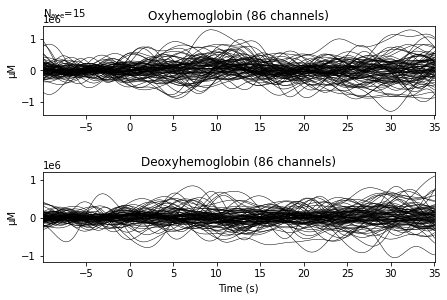

In [117]:
plot_events(raw)

Used Annotations descriptions: ['StartBlock', 'StartExperiment', 'StartRest']


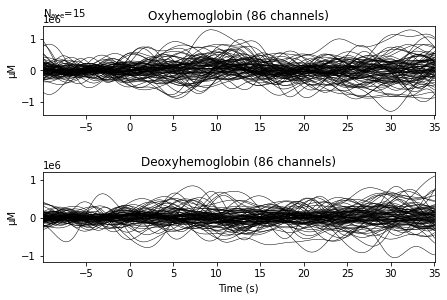

In [118]:
plot_events(short_chs)

In [ ]:
reject__criteria = dict(hbo=80e-6)
tmin, tmax = -5, 15

epochs = mne.Epochs(raw, events, event_id=events_id,
                   tmin=tmin, tmax=tmax, preload=True,
                   reject_by_annotation=True, event_repeated='merge', verbose=False)

In [ ]:
epochs.plot_drop_log();

In [ ]:
# for i in np.arange(0, 57, 2):
#     ch_hbo = epochs.ch_names[i]
#     ch_hbr = epochs.ch_names[i + 1]
#     epochs['StartTrial'].average().pick([ch_hbo, ch_hbr]).plot();
epochs['StartBlock'].average().plot();

In [122]:
block_times = events[events[:, 2] == 3][:, 0]

In [123]:
block_indexes = block_times * raw.info['sfreq']

In [124]:
events_id

{'StartBlock': 1, 'StartExperiment': 2, 'StartRest': 3}

In [125]:
data = raw.get_data()

In [128]:
sfreq = raw.info['sfreq']
blocks = [data[:, time - int(5 * sfreq) : time + int(35 * sfreq)] for time in block_times]
blocks = np.array(blocks[:-1])
blocks.shape

(15, 172, 284)

In [129]:
blocks_base = blocks[:, :, :int(sfreq * 5)]

In [130]:
blocks_base_mean = np.mean(blocks_base, axis=2)

In [131]:
blocks_base_mean_rep = np.repeat(blocks_base_mean[:, :, np.newaxis], blocks.shape[2], axis=2)
blocks_base_mean_rep.shape

(15, 172, 284)

In [132]:
blocks_corrected = blocks - blocks_base_mean_rep

In [133]:
blocks_avg = np.mean(blocks_corrected, axis=0)

In [134]:
blocks_avg  = np.mean(blocks, axis=0)
blocks_avg.shape

(172, 284)

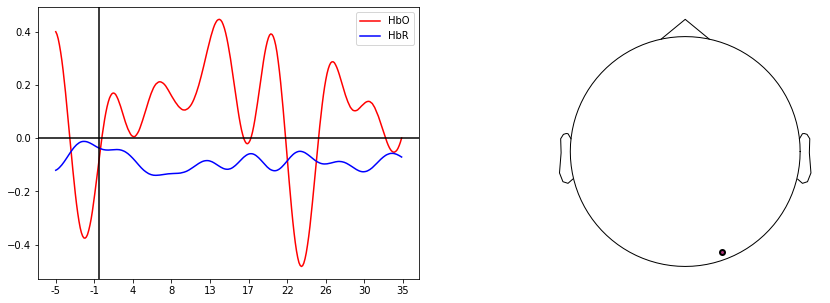

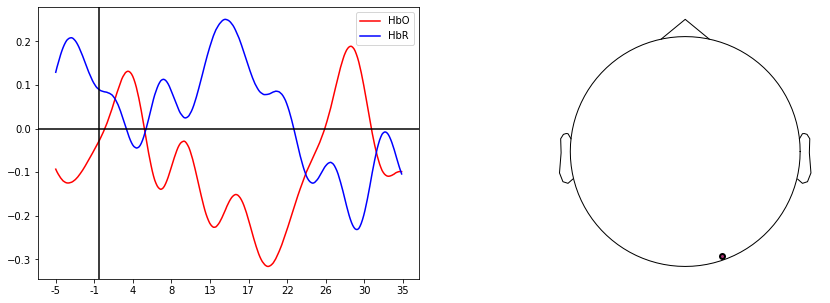

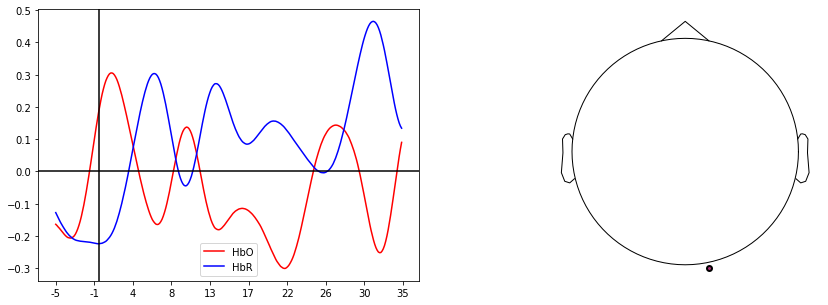

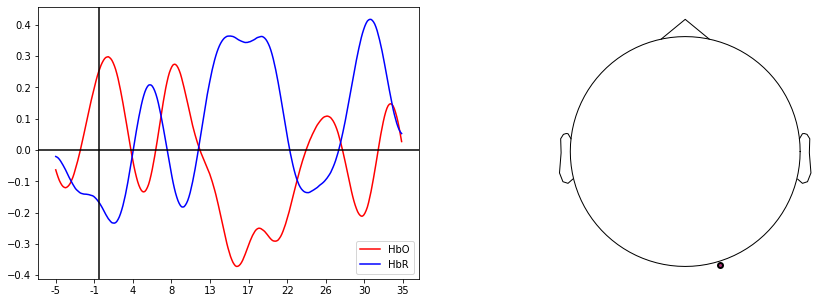

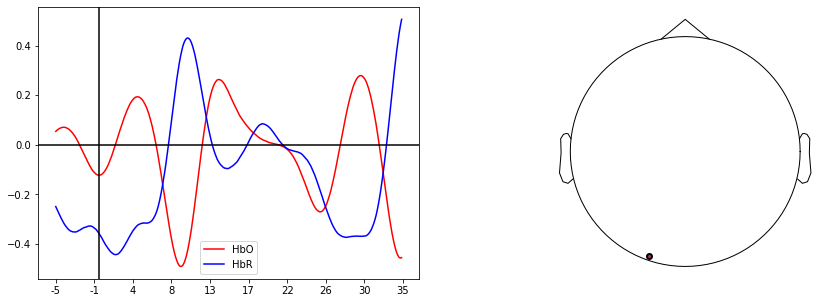

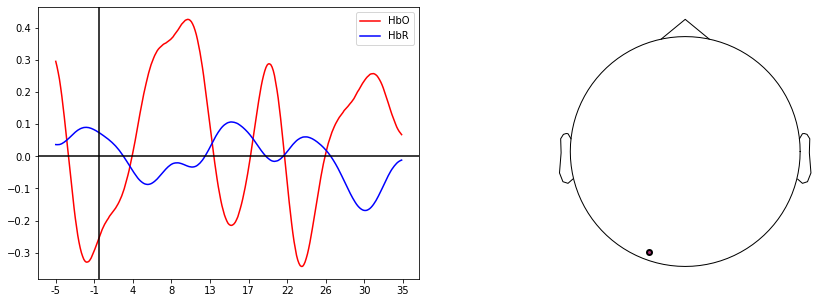

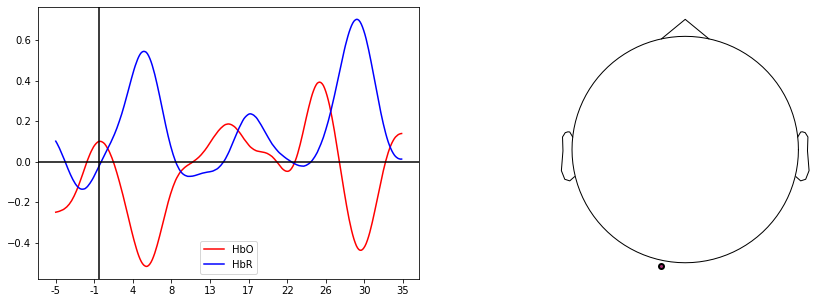

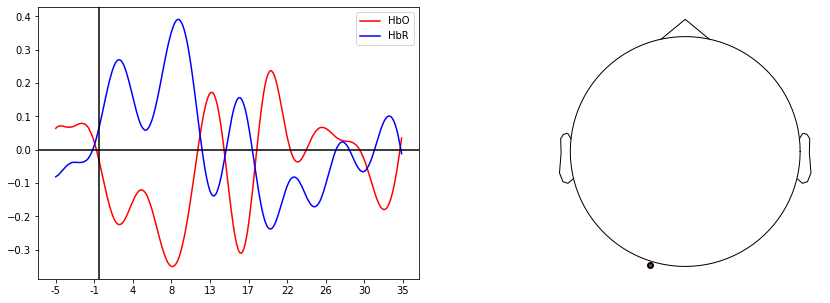

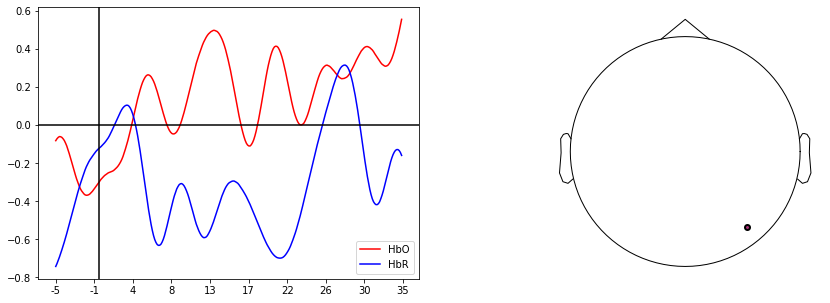

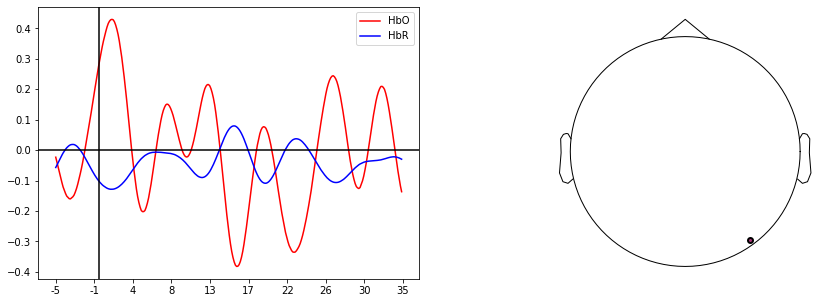

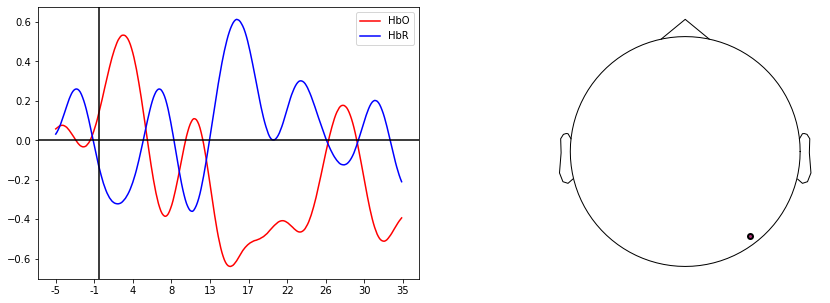

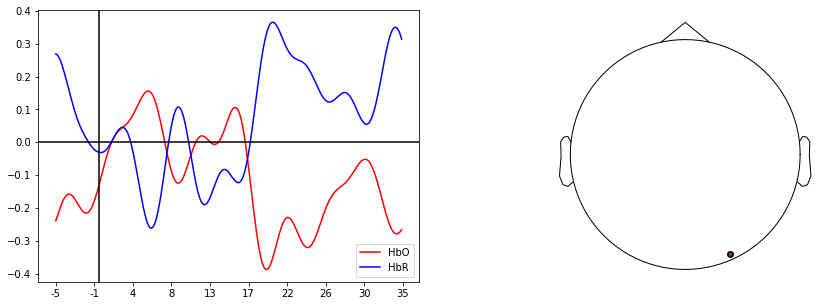

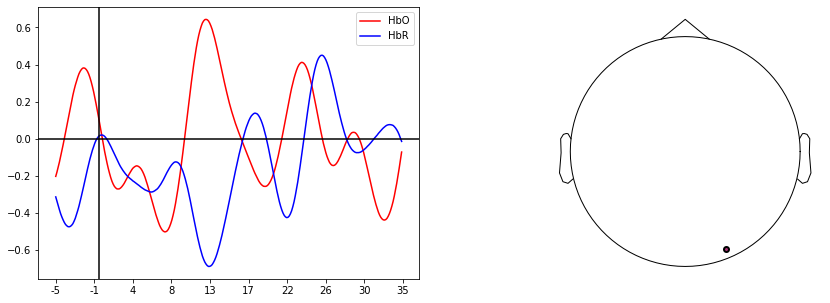

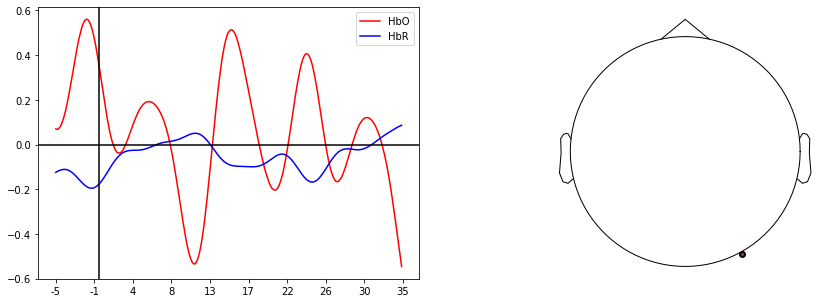

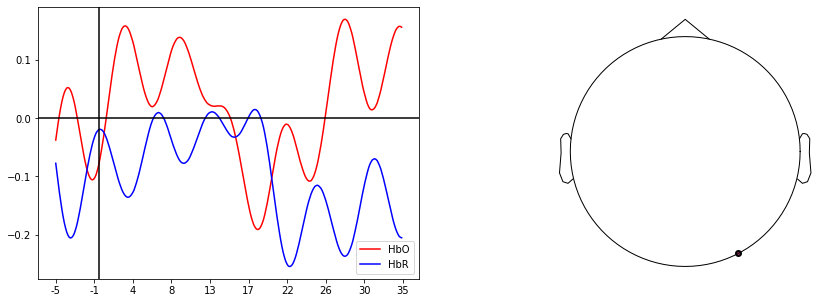

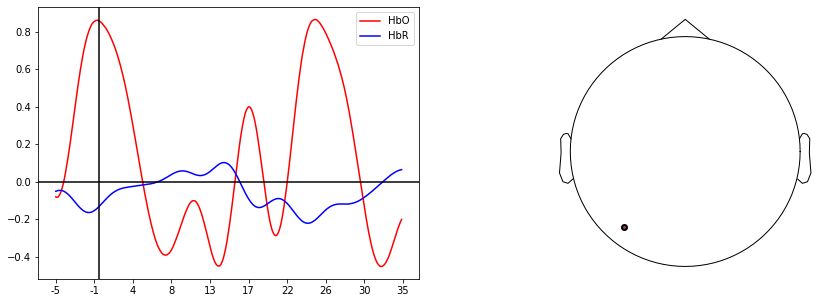

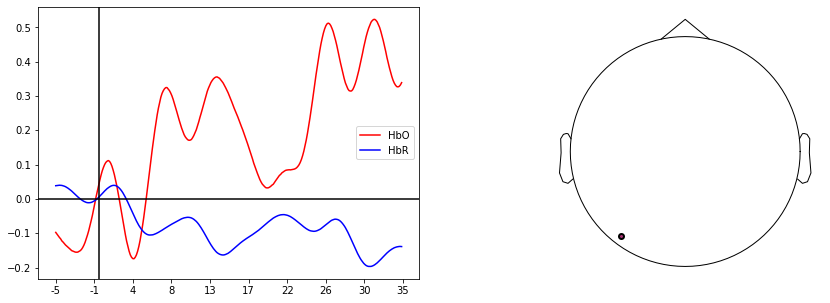

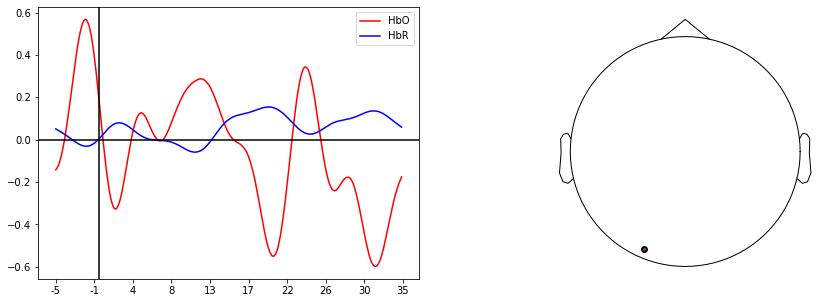

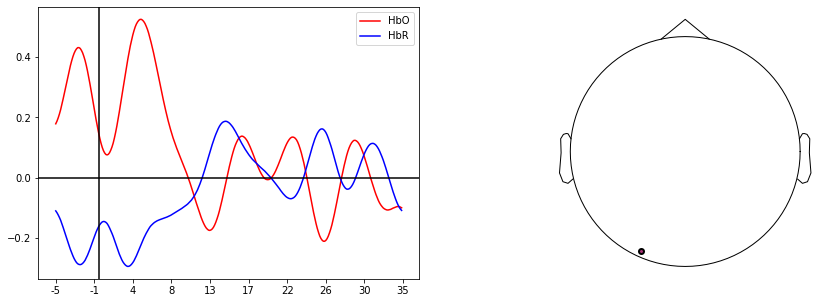

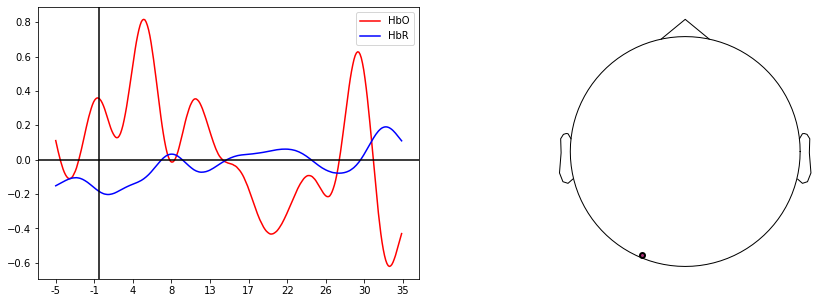

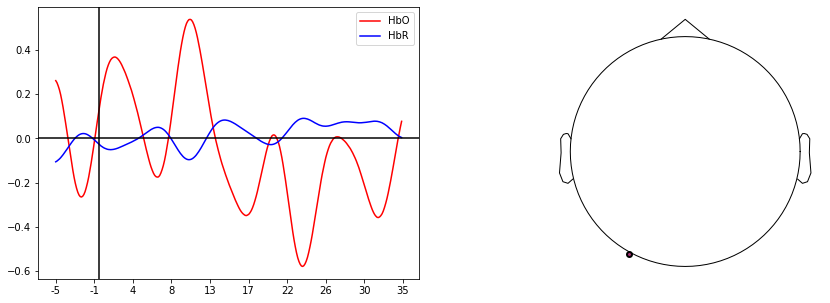

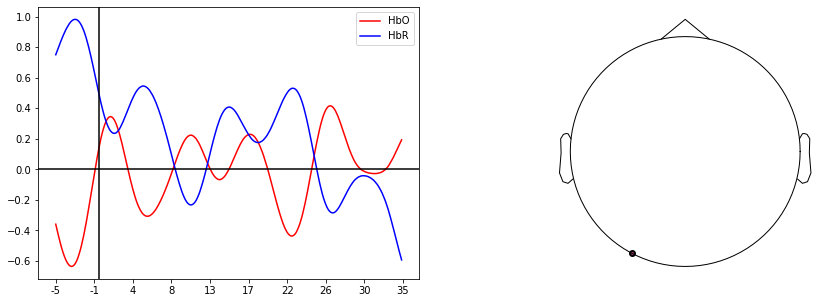

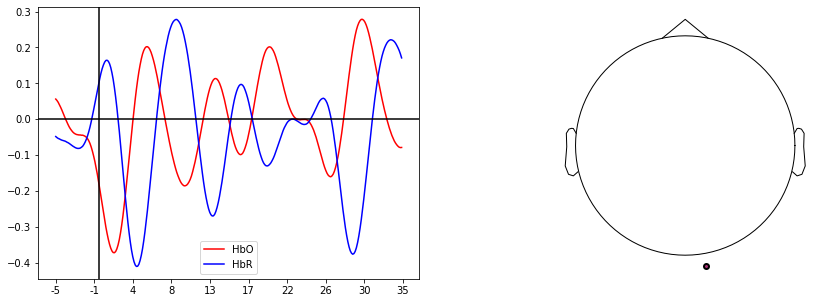

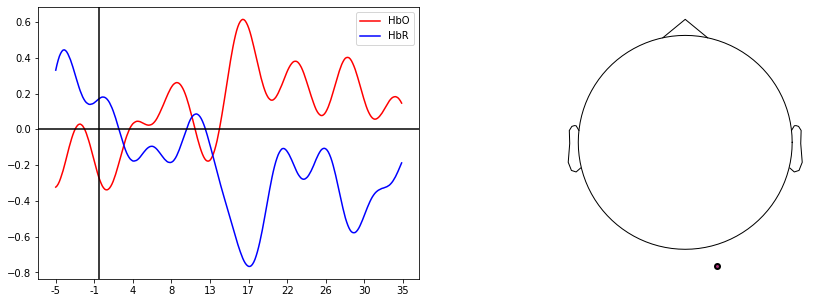

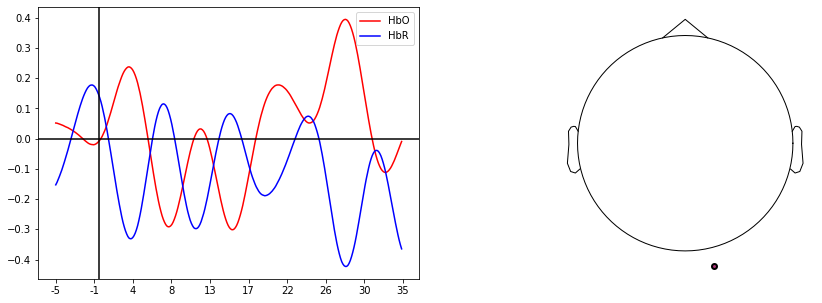

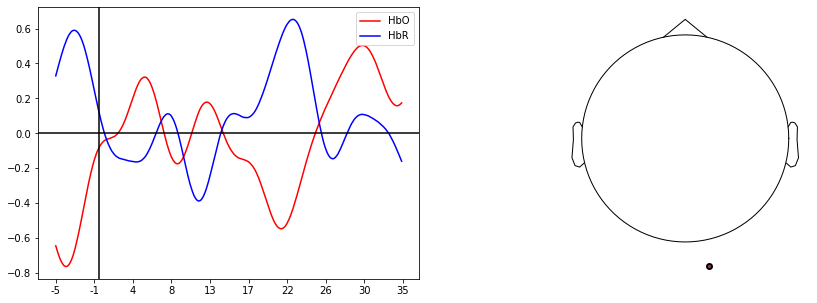

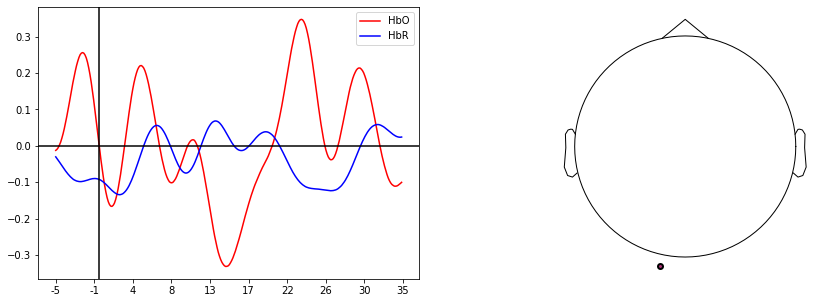

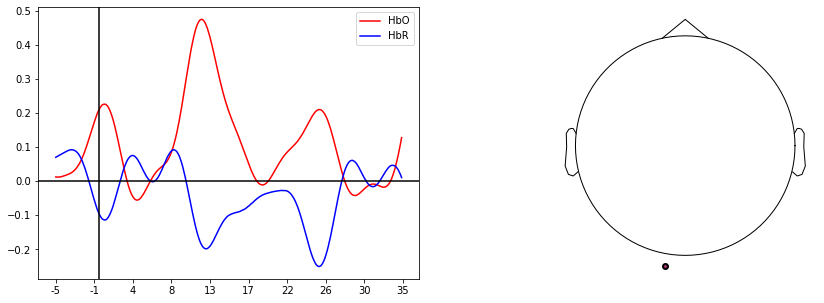

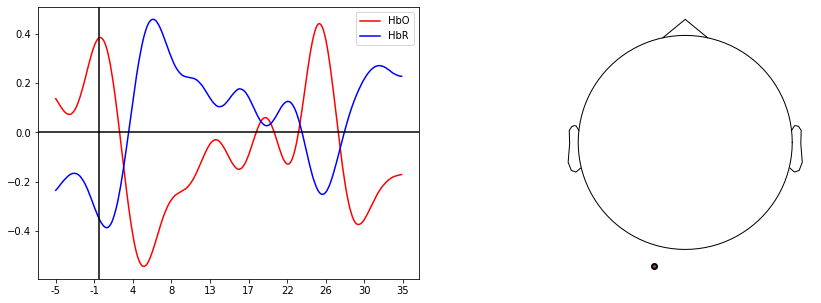

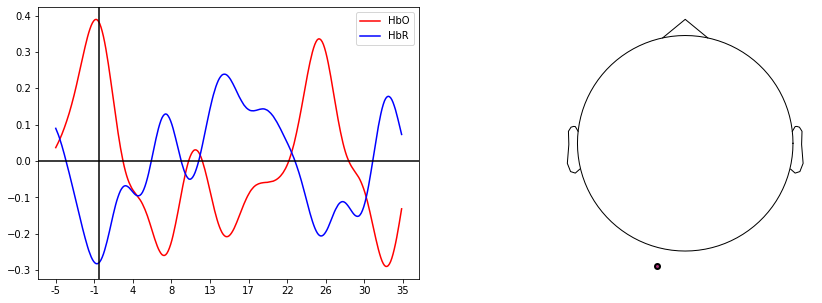

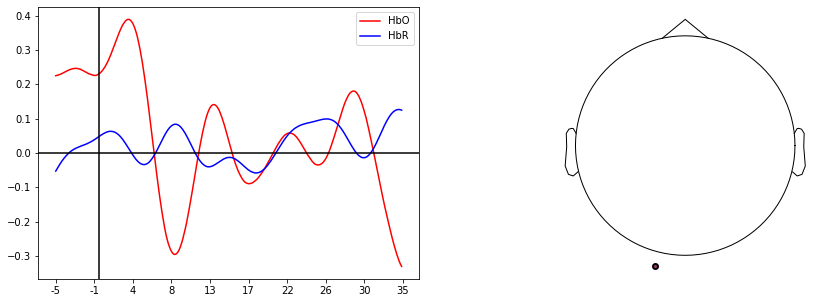

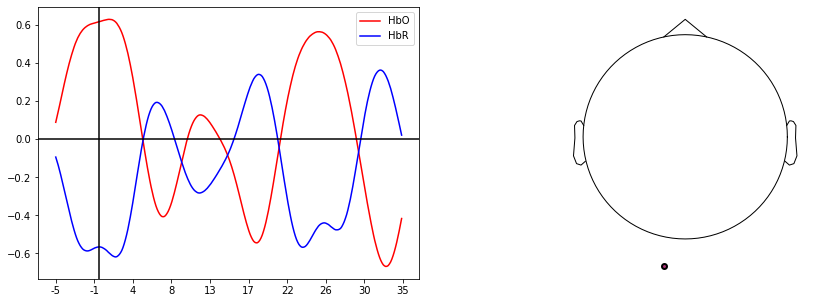

In [142]:
for i in np.arange(0, 64, 2):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(blocks_avg[i],'red', label='HbO' )
    plt.plot(blocks_avg[i + 1], 'blue', label='HbR')
    plt.xticks(np.linspace(0, len(blocks_avg[0]), 10), (np.linspace(0, len(blocks_avg[0]), 10)/7.14).round().astype(int) - 5)
    plt.axvline(x=int(5*raw.info['sfreq']), c='black')
    plt.axhline(y=0, c='black')
    plt.legend()
    ax = plt.subplot(122)
    raw.copy().pick(i).plot_sensors(axes=ax);
    plt.show()

In [ ]:
print(data.shape)

In [ ]:
plt.plot(data[0, 100:220]);

In [ ]:
raw.plot_psd(average=True);

In [ ]:
snirf_1.clean_channels

In [ ]:
picks_1 = snirf_1.pick('S20_', 'o')
picks_1_R = snirf_1.pick('S20_', 'r')
# picks_2 = snirf_2.pick('S21', 'O')
# picks_2_R = snirf_2.pick('S21', 'R')

In [ ]:
picks_1

In [ ]:
picks_1_00 = snirf_1.pick('S00', 'O')

In [ ]:
picks_1_00

In [ ]:
picks_1_12 = snirf_1.pick('S12_', 'o')
picks_1_14 = snirf_1.pick('S14_', 'o')
picks_1_20 = snirf_1.pick('S20_', 'o')
picks_1_22 = snirf_1.pick('S22_', 'o')
picks_1_28 = snirf_1.pick('S28_', 'o')
picks_1_30 = snirf_1.pick('S30_', 'o')
picks_1_36 = snirf_1.pick('S36_', 'o')

In [ ]:
picks_1_13 = snirf_1.pick('S13', 'o')
picks_1_15 = snirf_1.pick('S15', 'o')
picks_1_21 = snirf_1.pick('S21', 'o')
picks_1_23 = snirf_1.pick('S23', 'o')
picks_1_29 = snirf_1.pick('S29', 'o')
picks_1_31 = snirf_1.pick('S31', 'o')
picks_1_37 = snirf_1.pick('S37', 'o')

In [ ]:
picks_1_motor = [snirf_1.pick(motor, 'o').tolist() for motor in motors]

In [ ]:
picks_1_motor = [item for sublist in picks_1_motor for item in sublist]

In [ ]:
picks_1_motor = np.unique(np.array(picks_1_motor))

In [ ]:
picks_1_motor.shape

In [ ]:
picks_1_37_37d0 = snirf_1.pick('S37_D37d0', 'O')

In [ ]:
snirf_1.data_avg_left[0].shape

In [ ]:
snirf_1.data_avg_left.shape

In [ ]:
tmp = np.mean(snirf_2.data_avg_left[picks_2], axis=0)
base_time = int(5*snirf_1.sfreq)
tmp_base = tmp[: base_time]
# tmp_avg = np.mean(tmp [: int(5*snirf_1.sfreq)])
base_avg = np.mean(tmp_base) 
base_std = np.std(tmp_base)
tmp = (tmp - base_avg) / base_std

In [ ]:
def plot_signal(signal, label, sigma = 5):
    signal_filtered = gaussian_filter1d(signal, sigma)
    plt.plot(signal_filtered, label=label)
    plt.xticks(np.linspace(0, len(signal), 10), (np.linspace(0, len(signal), 10)/7.14).round().astype(int) - 5)
    plt.axvline(x=int(5*7.14))
    plt.axhline(y=0)
    plt.fill_betweenx(y=np.linspace(np.min(signal), np.max(signal), 100), x1=int(5*7.14), x2=int(20*7.14), alpha=.5, color='skyblue')
    plt.legend()

In [ ]:
def plot_base(signal, sfreq, label):
    tmp = np.mean(signal, axis=0)
    base_time = int(5*sfreq)
    tmp_base = tmp[: base_time]
    # tmp_avg = np.mean(tmp [: int(5*snirf_1.sfreq)])
    base_avg = np.mean(tmp_base) 
    base_std = np.std(tmp_base)
    tmp = (tmp - base_avg) / base_std
    plot_signal(tmp, label, 10)

In [ ]:
snirf_1.data_avg_left[picks_1_motor].shape

In [ ]:
plt.figure(figsize=(25, 10))
for pick in picks_1_22:
    plot_base([snirf_1.data_avg_left[pick]], snirf_1.sfreq, snirf_1.clean_channels[pick])

In [ ]:
all = []
for pick in picks_1_motor:
    all.append(snirf_1.data_avg_left[pick])
all = np.array(all)

In [ ]:
plt.figure(figsize=(25, 10))
plot_base(all, snirf_1.sfreq, 'AVG');

In [ ]:
plt.figure(figsize=(25, 10))
for pick in picks_1_14:
    plot_base([snirf_1.data_avg_left[pick]], snirf_1.sfreq, snirf_1.clean_channels[pick])

In [ ]:
plt.figure(figsize=(25, 10))
plot_base(snirf_1.data_avg_right[picks_1_14], snirf_1.sfreq, snirf_1.clean_channels[pick])

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_12], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_12], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_13], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_13], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_14], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_14], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_15], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_15], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_20], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_20], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_21], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_21], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_22], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_22], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_23], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_23], snirf_1.sfreq, 'Left')

In [ ]:
raw.copy().pick('S23')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_28], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_28], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_29], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_29], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_30], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_30], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_31], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_31], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_36], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_36], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_37], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_37], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_12], snirf_1.sfreq, '12')
plot_base(snirf_1.data_avg_right[picks_1_14], snirf_1.sfreq, '14')
plot_base(snirf_1.data_avg_right[picks_1_20], snirf_1.sfreq, '20')
plot_base(snirf_1.data_avg_right[picks_1_22], snirf_1.sfreq, '22')
plot_base(snirf_1.data_avg_right[picks_1_28], snirf_1.sfreq, '28')
plot_base(snirf_1.data_avg_right[picks_1_30], snirf_1.sfreq, '30')
plot_base(snirf_1.data_avg_right[picks_1_36], snirf_1.sfreq, '36')

In [ ]:
plot_base(snirf_1.data_avg_left[picks_1_12], snirf_1.sfreq, '12')
plot_base(snirf_1.data_avg_left[picks_1_14], snirf_1.sfreq, '14')
plot_base(snirf_1.data_avg_left[picks_1_20], snirf_1.sfreq, '20')
plot_base(snirf_1.data_avg_left[picks_1_22], snirf_1.sfreq, '22')
plot_base(snirf_1.data_avg_left[picks_1_28], snirf_1.sfreq, '28')
plot_base(snirf_1.data_avg_left[picks_1_30], snirf_1.sfreq, '30')
plot_base(snirf_1.data_avg_left[picks_1_36], snirf_1.sfreq, '36')

In [ ]:
# plot_base(snirf_1.data_avg_rest[picks_1_12], snirf_1.sfreq, '12')
# plot_base(snirf_1.data_avg_rest[picks_1_14], snirf_1.sfreq, '14')
# plot_base(snirf_1.data_avg_rest[picks_1_20], snirf_1.sfreq, '20')
# plot_base(snirf_1.data_avg_rest[picks_1_22], snirf_1.sfreq, '22')
# plot_base(snirf_1.data_avg_rest[picks_1_28], snirf_1.sfreq, '28')
# plot_base(snirf_1.data_avg_rest[picks_1_30], snirf_1.sfreq, '30')
# plot_base(snirf_1.data_avg_rest[picks_1_36], snirf_1.sfreq, '36')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1], snirf_1.sfreq, 'O')
plot_base(snirf_1.data_avg_right[picks_1_R], snirf_1.sfreq, 'R')

In [ ]:
plot_base(snirf_1.data_avg_left[picks_1], snirf_1.sfreq, 'O')
plot_base(snirf_1.data_avg_left[picks_1_R], snirf_1.sfreq, 'R')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_2], snirf_1.sfreq, 'O')
plot_base(snirf_1.data_avg_right[picks_2_R], snirf_1.sfreq, 'R')

In [ ]:
plot_base(snirf_1.data_avg_left[picks_2], snirf_1.sfreq, 'O')
plot_base(snirf_1.data_avg_left[picks_2_R], snirf_1.sfreq, 'R')

In [ ]:
plt.plot(tmp)

In [ ]:
plot_signal(np.mean(snirf_1.data_avg_left[picks_1], axis=0), 'O')
plot_signal(np.mean(snirf_1.data_avg_left[picks_1_R], axis=0), 'R')

In [ ]:
plot_signal(tmp, 'mammad', 7)

In [ ]:
snirf_1.data_avg_rest.shape

In [ ]:
print((picks_1))
print((picks_2))

In [ ]:
print(snirf_1.clean_channels[picks_1])
print(snirf_2.clean_channels[picks_2])

In [ ]:
tog = np.vstack((snirf_1.data_left[:,picks_1,:], snirf_2.data_left[:,picks_2,:]))

In [ ]:
plot_signal(signal=np.mean(np.mean(tog, axis= 0), axis=0), label='asd')

In [ ]:
plt.plot(np.mean(np.mean(tog, axis= 0), axis=0))

In [ ]:
snirf_2.data_right.shape

In [ ]:
snirf_1.data_right.shape

# Events

In [ ]:
events = get_events_from_snirf(path, False)

In [ ]:
events

# Data

In [ ]:
data = snirf.get_data()

In [ ]:
nans = np.isnan(data)
nans_sum = np.sum(nans, axis=1)
nans_ids = nans_sum > 0

In [ ]:
print(nans_ids.shape)
print(data.shape)
len(snirf.ch_names)

In [ ]:
clean_data = data[~nans_ids, :]
clean_channels = np.array(snirf.ch_names)[~nans_ids]

In [ ]:
print(clean_data.shape)
clean_channels.shape

# Channels


# Plot

In [ ]:
def get_duration(events):
    duration = events[events['Duration'].round() >0].Duration.min().round().astype(int)
    return duration

In [ ]:
def get_start_indexes(events, sampling_rate):
    start_indexes = (events.Timestamp.values*sampling_rate).round().astype(int)
    return start_indexes

In [ ]:
def get_events_start_block(events, label):
    if label == 'Rest':
        events = events[(events.Duration > 2) & (events.Event == 'StartRest')]
    else:
        events = events[(events.BlockType == label) & (events.Event == 'StartBlock')]
    return events

In [ ]:
def get_data(all_data, start_indexes, duration):
    tmp = [all_data[:, start_index:start_index + (duration*sampling_rate).round().astype(int)] for start_index in start_indexes]
    # print([np.shape(t) for t in tmp])
    data = np.array(tmp)
    return data

In [ ]:
def get_data_avg(data):
    data_avg = np.mean(data, axis=0)
    return data_avg

In [ ]:
def _plot(snirf, data, duration):
    times = range(duration)
    channel_names = [x['ch_name'] for x in snirf.info['chs']]
    is_hbo = np.array([1 if channel_name.endswith(
       'HbO') else 0 for channel_name in channel_names], dtype=bool)
    channel_locations_3d = [x['loc'][:3] for x in snirf.info['chs']]

    _, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].pcolor(times, np.arange(np.sum(is_hbo)), data[is_hbo, :], shading='nearest')
    ax[0].set_title('HbO')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Channel number')
    ax[1].pcolor(times, np.arange(np.sum(~is_hbo)),
                data[~is_hbo, :], shading='nearest')
    ax[1].set_title('HbR')
    ax[1].set_xlabel('Time [s]')
    # plt.show() 

In [ ]:
def plot(snirf, all_data, all_events, sampling_rate, label):
    events = get_events_start_block(all_events, label)
    duration = get_duration(events) 
    start_indexes = get_start_indexes(events, sampling_rate)
    data = get_data(all_data, start_indexes, duration)
    data_avg = get_data_avg(data)
    plt.pcolor( data_avg, shading='auto', cmap='binary')
    # _plot(snirf, data_avg, duration)
    return data, data_avg

In [ ]:
np.linspace(0, 10, 20)

In [ ]:
sampling_rate = snirf.info['sfreq']  #7.14 #8.26 #7.14

In [ ]:
data_right, data_avg_right = plot(snirf, clean_data, events, sampling_rate, 'Right')

In [ ]:
data_left, data_avg_left = plot(snirf, clean_data, events, sampling_rate, 'Left')

In [ ]:
data_rest, data_avg_rest = plot(snirf, clean_data, events, sampling_rate, 'Rest')

In [ ]:
clean_channels[:10]

In [ ]:
def find_channels(start, channels, o2):
    out = [ch for ch in channels if ch.startswith(start) and ch.endswith(o2) ]
    out = np.array(out)
    return out
def find_channel_indexes(channels, filt):
    out = [i for i, ch in enumerate(channels) if ch in filt]
    out = np.array(out)
    return out
def pick(start, channels, o2):
    tmp = find_channels(start,channels, o2)
    indexes = find_channel_indexes(channels, tmp)
    return indexes

In [ ]:
def find_channels(start, channels, o2):
    out = [ch for ch in channels if ch.startswith(start) and ch.endswith(o2) ]
    out = np.array(out)
    return out

In [ ]:
def find_channel_indexes(channels, filt):
    out = [i for i, ch in enumerate(channels) if ch in filt]
    out = np.array(out)
    return out

In [ ]:
def pick(start, channels, o2):
    tmp = find_channels(start,channels, o2)
    indexes = find_channel_indexes(channels, tmp)
    return indexes

In [ ]:
def pick_data(data, picks):
    data_pick = data[picks, :]
    return data_pick

In [ ]:
def plot_signal(signal, label, sigma = 5):
    signal_filtered = gaussian_filter1d(signal, sigma)
    plt.plot(signal_filtered, label=label)
    plt.xticks(np.linspace(0, len(signal), 10), (np.linspace(0, len(signal), 10)/7.14).round().astype(int) - 5)
    plt.axvline(x=int(5*7.14))
    plt.axhline(y=0)
    plt.fill_betweenx(y=np.linspace(np.min(signal), np.max(signal), 100), x1=int(5*7.14), x2=int(20*7.14), alpha=.5)
    plt.legend()

In [ ]:
np.linspace(-1, 1, 10)

In [ ]:
def plot_signal_pick(data, picks, label):
    data_pick = data[picks, :]
    data_avg = np.mean(data_pick, axis=0)
    plot_signal(data_avg, label)

In [ ]:
np.vstack((snirf_1.data_avg_right, snirf_2.data_avg_right)).shape

In [ ]:
pick_o = pick('S21', clean_channels, 'HbO')
pick_r = pick('S21', clean_channels, 'HbR')
pick_00 = pick('S00', clean_channels, 'HbO')

In [ ]:
pick_o_20 = pick('S20', clean_channels, 'HbO')

In [ ]:
snirf_1.data

In [ ]:
data_pick_right = pick_data(data_avg_right, pick_o)
data_pick_right_r = pick_data(data_avg_right, pick_r)
data_pick_left = pick_data(data_avg_left, pick_o)
data_pick_left_r = pick_data(data_avg_left, pick_r)
data_pick_rest = pick_data(data_avg_rest, pick_o)

In [ ]:
plot_signal_pick(data_avg_left, pick_00, 'left')
plot_signal_pick(data_avg_rest, pick_00, 'rest')
plot_signal_pick(data_avg_right, pick_00, 'right')

In [ ]:
plot_signal_pick(data_avg_left, pick_o, 'left')
plot_signal_pick(data_avg_rest, pick_o, 'rest')
plot_signal_pick(data_avg_right, pick_o, 'right')

In [ ]:
plot_signal_pick(data_avg_right, pick_o_20, '20')
plot_signal_pick(data_avg_right, pick_o, '21')

In [ ]:
plot_signal_pick(data_avg_left, pick_o_20, '20')
plot_signal_pick(data_avg_left, pick_o, '21')

In [ ]:
plot_signal_pick(data_avg_right, pick_o, 'o')
plot_signal_pick(data_avg_right, pick_r, 'r')

In [ ]:
plot_signal_pick(data_avg_left, pick_o, 'o')
plot_signal_pick(data_avg_left, pick_r, 'r')

In [ ]:
plot_signal_pick(data_avg_right, pick_o, 'o')
plot_signal_pick(data_avg_right, pick_r, 'r')

In [ ]:
plot_signal_pick(data_avg_right, pick_o, 'right')
plot_signal_pick(data_avg_left, pick_o, 'left')

In [ ]:
plot_signal_pick(data_avg_left - data_avg_rest[:, :107] , pick_o, 'left')
plot_signal_pick(data_avg_right - data_avg_rest[:, :np.shape(data_avg_right)[1]], pick_o, 'right')
# plot_signal_pick(data_avg_rest[:, :107], pick_o, 'rest')

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
np.array([[1, 2, 3], [3, 4, 5]]).shape

In [ ]:
stats, p_values = ttest_ind(data_pick_left[:, :107], data_pick_right[:, :107], axis=1)

In [ ]:
plt.bar(clean_channels[pick_o],  p_values)
plt.xticks(rotation = -89)
plt.show()

In [ ]:
# plot_signal(np.mean(data_avg_left[indexes], axis=0), 'meh')

In [ ]:
plt.plot(data_avg_right[0, :])
plt.plot(data_avg_right[2, :])
plt.xticks(np.linspace(0, len(data_avg_right[0, :]), 10), (np.linspace(0, len(data_avg_right[0, :]), 10)/sampling_rate).round().astype(int))
plt.show()

In [ ]:
print(data_right.shape)
print(data_avg_right.shape)

In [ ]:
print(data_left.shape)
print(data_avg_left.shape)

In [ ]:
signal_right = np.mean(data_avg_right, axis = 0)
signal_left = np.mean(data_avg_left, axis = 0)
# signal_rest = np.mean(data_avg_rest, axis = 0)

In [ ]:
plt.figure(figsize=(25, 10))
plot_signal(signal_right, 'right')
plot_signal(signal_left, 'left')
# plot_signal(signal_rest, 'rest')
# plt.legend()
plt.show()

In [ ]:
np.linspace(0, 10, 2)

# Filter

In [ ]:
filtered_data = gaussian_filter1d(clean_data, 5, axis=1)

In [ ]:
filtered_data.shape

# Classify

In [ ]:
data_right_filt, data_avg_right_filt = plot(snirf, filtered_data, events, sampling_rate, 'Right')
data_left_filt, data_avg_left_filt = plot(snirf, filtered_data, events, sampling_rate, 'Left')

In [ ]:
data_right_filt.shape

In [ ]:
def make_window(data, index, window_length):
    wind = data[:, :, index: index+window_length]
    return wind

In [ ]:
def window_to_feature(window):
    [times, channels, points] = np.shape(window)
    # features = np.ones((times, channels * 3))
    _mean = np.mean(window, axis = 2)
    _min = np.min(window, axis = 2)
    _max = np.max(window, axis = 2)
    features = np.hstack((_mean, _min, _max))
    # features[:, 3:] = data[:]
    return features

In [ ]:
def make_x_y(features):
    shape = np.shape(features)
    X = np.vstack(features)
    y = np.hstack([(i+1) * np.ones(shape[1]) for i in range(len(features))])
    return X, y

In [ ]:
def classify(X, y):
    # clf = SVC(kernel='linear', C=1, random_state=42)
    clf = MLPClassifier(random_state=1, max_iter=10000)
    # clf = OneVsRestClassifier(SVC())#.fit(X, y)
    scores = cross_val_score(clf, X, y, cv=5)
    return scores

In [ ]:
s_freq = snirf.info['sfreq']
window_length = int(1 * s_freq)
max_index = int(10 * s_freq)
scores_all = np.zeros((max_index))
picks_21 = pick('S21', clean_channels, 'HbO')
picks_20 = pick('S20', clean_channels, 'HbO')
picks_22 = pick('S22', clean_channels, 'HbO')
picks = np.hstack(( picks_22))
for i in range(max_index):
    window_left = make_window(data_left_filt[:, picks, :], i, window_length)
    window_right = make_window(data_right_filt[:, picks, :], i, window_length)
    feature_left = window_to_feature(window_left)
    feature_right = window_to_feature(window_right)
    X, y = make_x_y([feature_left, feature_right])
    scores = classify(X, y)
    scores_all [i] = scores.mean()

In [ ]:
plot_signal(scores_all, 'accuracy')

In [ ]:
y

# T Test

In [ ]:
np.nanmean(data_right, axis= 2)

In [ ]:
mean_time_right = np.nanmean(( data_right), axis = 2)
mean_time_left = np.nanmean((data_left), axis = 2)

In [ ]:
mean_time_right

In [ ]:
mean_time_right = drop_nan(mean_time_right)
mean_time_left = drop_nan(mean_time_left)

In [ ]:
mean_time_left

In [ ]:
mean_chan_right = np.mean(mean_time_right, axis= 1)
mean_chan_left = np.mean(mean_time_left, axis= 1)

In [ ]:
mean_chan_left

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
ttest_ind(mean_chan_right, mean_chan_left)

In [ ]:
mean_chan_left.shape

In [ ]:
def drop_nan(data):
    clean = data[np.sum(np.isnan(data), axis=1) == 0]
    return clean

In [ ]:
tmp = np.mean(drop_nan(data_avg_rest), axis = 0)

In [ ]:
plt.plot((np.mean(drop_nan(data_avg_left), axis=0) ), label='Left')
plt.plot((np.mean(drop_nan(data_avg_right), axis= 0)), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest), axis = 0) , label='Rest')
plt.legend()
plt.title('Both')
plt.show()

In [ ]:
channel_names = [x['ch_name'] for x in snirf.info['chs']]
is_hbo = np.array([1 if channel_name.endswith(
       'HbO') else 0 for channel_name in channel_names], dtype=bool)

In [ ]:
plt.plot(np.mean(drop_nan(data_avg_left[is_hbo]), axis=0), label='Left')
plt.plot(np.mean(drop_nan(data_avg_right[is_hbo]), axis= 0), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest[is_hbo]), axis = 0), label='Rest')
plt.legend()
plt.title('HBO')
plt.show()

In [ ]:
plt.plot(np.mean(drop_nan(data_avg_left[~is_hbo]), axis=0), label='Left')
plt.plot(np.mean(drop_nan(data_avg_right[~is_hbo]), axis= 0), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest[~is_hbo]), axis = 0), label='Rest')
plt.legend()
plt.title('HBR')
plt.show()

In [ ]:
np.mean(data_avg_left, axis=0)

In [ ]:
duration_right = get_duration(events_right)
start_index_right = get_start_indexes(events_right, 8.26)

In [ ]:
data_right = np.array([data[:, start_index:start_index + duration_right] for start_index in start_index_right])

In [ ]:
data_right_avg = np.mean(data_right, axis=0)

In [ ]:
plot(snirf, data_right_avg, duration_right)